In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

from torch_geometric.nn import GCNConv

from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid
import umap

from torch_geometric.nn import GNNExplainer

from utilities import *
from activation_classifier import *
import random
import models

set_rc_params()

# ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
class BA_Shapes_GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes, prot_index, train_mask, name):
        super(BA_Shapes_GCN, self).__init__()

        self.name = name
        self.prot = prot_index
        self.train_mask = train_mask

        self.conv0 = GCNConv(num_in_features, num_hidden_features)
        self.conv1 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv3 = GCNConv(num_hidden_features, num_hidden_features)

        # linear layers
        self.linear = nn.Sequential(nn.Linear(num_hidden_features, num_hidden_features),
                                    nn.ReLU(),
                                    nn.Linear(num_hidden_features, num_classes))

    def relative_rep(self, x, anchor_indexes):
        anchors = x[anchor_indexes]
        result = torch.Tensor()
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        for t in anchors:
            # tmp = torch.clamp(cos(x, t).unsqueeze(dim=-1), min=0, max=1)
            tmp = (cos(x, t).unsqueeze(dim=-1) - (-1)) / (1 - (-1))
            result = torch.cat((result, tmp), dim=-1)
        # result = F.softmax(result, dim=-1)
        # result = torch.nn.functional.normalize(result, dim=0)
        return result

    def y_composition(self, x, out_proto):
        y = F.log_softmax(torch.mm(x, out_proto), dim=-1)

        return y

    def choose_prototype(self, x):
        kmeans_model = KMeans(n_clusters=k, random_state=0)
        x_tmp = x.detach().numpy()
        kmeans_model = kmeans_model.fit(x_tmp[self.train_mask])

        res_sorted = kmeans_model.transform(x_tmp[self.train_mask])
        proto = []
        for i in range(k):
            distances = res_sorted[:, i]
            train_index = np.argsort(distances)[::][0]
            true_index =  np.array(range(x.shape[0]))[self.train_mask][train_index]
            proto += [true_index]
        return proto

    def zca_whitening_matrix(self, X):
        """
        Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
        INPUT:  X: [M x N] matrix.
            Rows: Variables
            Columns: Observations
        OUTPUT: ZCAMatrix: [M x M] matrix
        """
        # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
        sigma = np.cov(X, rowvar=True) # [M x M]
        # Singular Value Decomposition. X = U * np.diag(S) * V
        U,S,V = np.linalg.svd(sigma)
            # U: [M x M] eigenvectors of sigma.
            # S: [M x 1] eigenvalues of sigma.
            # V: [M x M] transpose of U
        # Whitening constant: prevents division by zero
        epsilon = 1e-5
        # ZCA Whitening matrix: U * Lambda * U'
        ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
        return ZCAMatrix

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.relu(x)

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        #x = F.relu(x)

        self.prot = self.choose_prototype(x)

        # qn = torch.norm(x, p=2, dim=1, keepdim=True)
        # x = x.div(qn.expand_as(x))

        # x_clone = x.clone().detach().numpy()
        #
        # zca_matrix = torch.tensor(self.zca_whitening_matrix(x_clone).astype(np.float32))
        # x = torch.mm(zca_matrix, x)


        # orthogonal = torch.mm(x[self.prot], x[self.prot].T).sum()

        x_rel = self.relative_rep(x, self.prot)
        orthogonal = x_rel[self.prot].sum()/len(self.prot) - 1

        out_proto = F.log_softmax(self.linear(x[self.prot]), dim=-1)

        out = self.y_composition(x_rel, out_proto)

        return out, x_rel, out_proto, orthogonal


In [4]:
# general parameters
dataset_name = "BA_Shapes"

model_type = BA_Shapes_GCN
load_pretrained = False

# hyperparameters
k = 3

# other parameters
train_test_split = 0.8
num_hidden_units = 20
num_classes = 4

epochs = 3000
lr = 0.001

In [5]:
# define anchors_index
def anchor_index(size, k):
    anchors = np.random.choice(size, size=k, replace=False)
    return anchors

def anchor_index_for_classes(dataset, labels, k, n_classes, train_mask):
    anchors = []
    for c in range(n_classes):
        index_tmp = np.array(range(dataset.shape[0]))[train_mask][labels[train_mask] == c]
        anchors += list(anchor_index(index_tmp, k))
    return anchors

In [6]:
def test(model, node_data_x, node_data_y, edge_list, mask):
    # enter evaluation mode
    model.eval()

    correct = 0
    pred, _, _, _ = model(node_data_x, edge_list)
    pred = pred.max(dim=1)[1]

    correct += pred[mask].eq(node_data_y[mask]).sum().item()
    return correct / (len(node_data_y[mask]))

In [7]:
def train(model, data, epochs, lr, path):
    # register hooks to track activation
    model = register_hooks(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # list of accuracies
    train_accuracies, test_accuracies, train_losses, test_losses = list(), list(), list(), list()

    # get data
    x = data["x"]
    edges = data["edges"]
    y = data["y"]
    train_mask = data["train_mask"]
    test_mask = data["test_mask"]


    # iterate for number of epochs
    for epoch in range(epochs):
            # set mode to training
            model.train()
            optimizer.zero_grad()

            # input data
            out, _, out_proto, ortoghonal = model(x, edges)

            # calculate loss
            loss = F.nll_loss(out[train_mask], y[train_mask]) + F.nll_loss(out_proto, y[model.prot]) + 0.2*ortoghonal
            # loss = F.nll_loss(out[train_mask], y[train_mask]) + 0.2*ortoghonal
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                test_loss = F.nll_loss(out[test_mask], y[test_mask]) + 0.2*ortoghonal

                # get accuracy
                train_acc = test(model, x, y, edges, train_mask)
                test_acc = test(model, x, y, edges, test_mask)

            ## add to list and print
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())

            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss.item(), train_acc, test_acc), end = "\r")

            # if train_acc >= 0.95 and test_acc >= 0.95:
            #     break
    # plut accuracy graph
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Testing Accuracy")
    plt.title(f"Accuracy of {model.name} Model during Training")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(path, f"model_accuracy_plot.png"))
    plt.show()

    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Testing Loss")
    plt.title(f"Loss of {model.name} Model during Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(path, f"model_loss_plot.png"))
    plt.show()

    # save model
    torch.save(model.state_dict(), os.path.join(path, "model.pkl"))

    with open(os.path.join(path, "activations.txt"), 'wb') as file:
        pickle.dump(activation_list, file)


In [8]:
paths = prepare_output_paths(dataset_name, k)

G, labels = load_syn_data(dataset_name)
data = prepare_syn_data(G, labels, train_test_split)
k=12
#prot_indexes = list(anchor_index(np.array(range(data['train_mask'].shape[0]))[data['train_mask']], k))
prot_indexes = list(anchor_index_for_classes(data['x'], data['y'], k, num_classes, data['train_mask']))
model = model_type(data["x"].shape[1], num_hidden_units, num_classes, prot_indexes, data['train_mask'], "BA-Shapes")

if load_pretrained:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(os.path.join(paths['base'], "model.pkl")))
    model.eval()
    
    with open(os.path.join(paths['base'], "activations.txt"), 'rb') as file:
        activation_list = pickle.loads(file.read())
        
else:
    model.apply(weights_init)
    train(model, data, epochs, lr, paths['base'])

Task: Node Classification
Number of features:  700
Number of labels:  700
Number of classes:  700
Number of edges:  2
 BA_Shapes_GCN(
  (conv0): GCNConv(1, 20)
  (conv1): GCNConv(20, 20)
  (conv2): GCNConv(20, 20)
  (conv3): GCNConv(20, 20)
  (linear): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=4, bias=True)
  )
)
conv0 GCNConv(1, 20)
conv1 GCNConv(20, 20)
conv2 GCNConv(20, 20)
conv3 GCNConv(20, 20)
linear Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=4, bias=True)
)
linear.0 Linear(in_features=20, out_features=20, bias=True)
linear.1 ReLU()
linear.2 Linear(in_features=20, out_features=4, bias=True)


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [14]:
def get_subgraph(idx, y, edges, num_expansions):
    graphs = []
    color_maps = []
    labels = []
    node_labels = []

    df = pd.DataFrame(edges)

    # get neighbours
    neighbours = list()
    neighbours.append(idx)

    for i in range(0, num_expansions):
        new_neighbours = list()
        for e in edges:
            if (e[0] in neighbours) or (e[1] in neighbours):
                new_neighbours.append(e[0])
                new_neighbours.append(e[1])

        neighbours = neighbours + new_neighbours
        neighbours = list(set(neighbours))

    new_G = nx.Graph()
    df_neighbours = df[(df[0].isin(neighbours)) & (df[1].isin(neighbours))]
    remaining_edges = df_neighbours.to_numpy()
    new_G.add_edges_from(remaining_edges)

    color_map = []
    node_label = {}
    for node in new_G:
        if node == idx:
            color_map.append('green')
        else:
            color_map.append('pink')


    return new_G, color_map, y[idx], node_label

In [15]:
def plot_samples(indices, y, edges, num_expansions, sim):

    idx_sim = sorted(list(zip(indices[1:], sim)), key=lambda x:x[1])
    top_idx_sim = idx_sim[-5:] + idx_sim[:5]
    top_idx_sim = list(zip(*top_idx_sim))
    indices = [indices[0]] + list(top_idx_sim[0])
    sim = list(top_idx_sim[1])

    sim = [1.0] + sim

    fig, axes = plt.subplots(1, len(indices), figsize=(18, 3 * 1 + 2))
    fig.suptitle(f'Nearest Instances to Cluster Centroid for  Activations of Layer', y=1.005)

    ax_list = axes
    for index, ax in enumerate(axes):
        tg, cm, labels, node_labels = get_subgraph(indices[index], y, edges, num_expansions)

        nx.draw(tg, node_color=cm, with_labels=True, ax=ax)
        ax.set_title(f"label {labels}, sim {sim[index]:.3}", fontsize=14)

    plt.show()



In [16]:
x = data["x"]
edges = data["edges"]
y = data["y"]
train_mask = data["train_mask"]
test_mask = data["test_mask"]
print(test(model, x, y, edges, train_mask))
print(test(model, x, y, edges, test_mask))

0.8619402985074627
0.8719512195121951


In [17]:
pred, x_rep, out_prot, _ = model(x, edges)
prot = model.prot
print(y[699], pred[699], x_rep[699])
print(out_prot)

tensor(3) tensor([-3.5670, -1.8056, -0.6600, -1.2361], grad_fn=<SelectBackward0>) tensor([0.9910, 0.0038, 0.4957, 0.0057, 0.3297, 0.9964, 0.9976, 0.6763, 0.0111,
        0.0573, 0.0133, 0.7664], grad_fn=<SelectBackward0>)
tensor([[-2.4801, -0.8547, -1.2061, -1.6530],
        [-0.1788, -1.9810, -4.7667, -4.0561],
        [-3.2204, -0.1375, -2.8059, -3.5728],
        [-0.3681, -1.2006, -5.9717, -5.4299],
        [-0.6568, -4.8500, -2.0898, -1.0500],
        [-2.4772, -0.9697, -1.1410, -1.5262],
        [-1.7045, -1.3624, -1.1997, -1.3440],
        [-0.9978, -7.1266, -2.1862, -0.6575],
        [-0.4075, -1.7542, -2.7278, -2.3405],
        [-0.1713, -3.2601, -3.3607, -2.4734],
        [-0.6022, -0.8402, -4.7181, -4.4350],
        [-3.5339, -0.2557, -1.9776, -2.8474]], grad_fn=<LogSoftmaxBackward0>)


In [18]:
similarities = list(x_rep[699].detach().numpy())

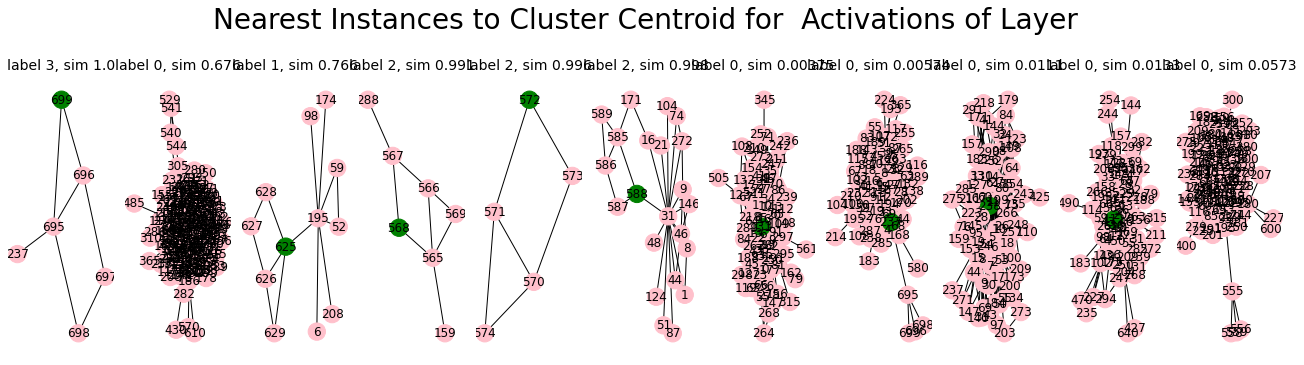

In [19]:
plot_samples([699] + prot, y.numpy(), torch.transpose(edges, 1, 0).numpy(), 2, similarities)

# Dimensionality Reduction

### TSNE

/Users/gabri/GCExplainer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gabri/GCExplainer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


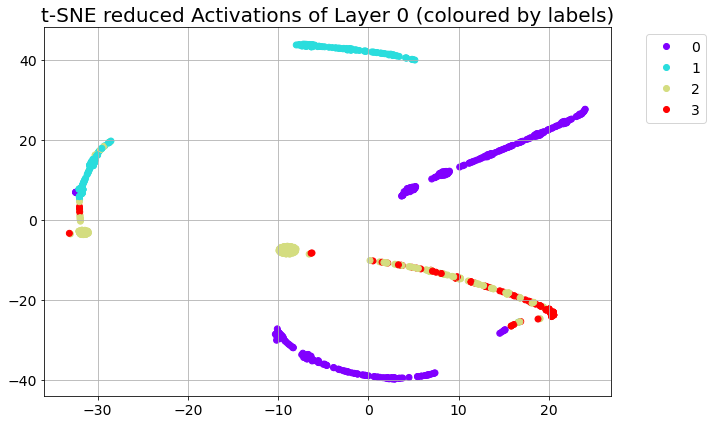

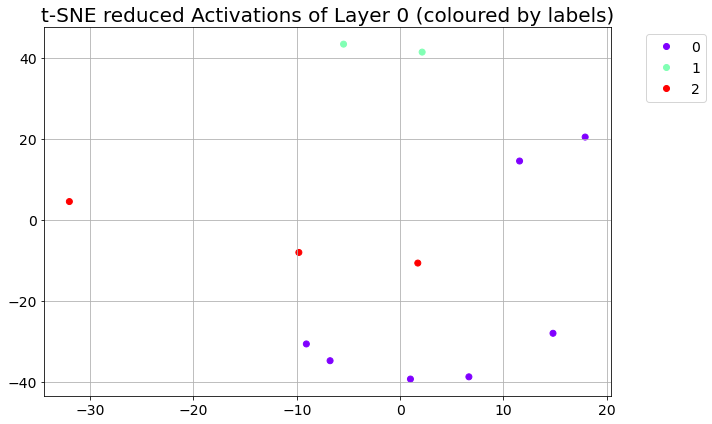

In [20]:
# TSNE conversion
tsne_models = []
tsne_data = []


activation = x_rep.detach().numpy()
tsne_model = TSNE(n_components=2)
d = tsne_model.fit_transform(activation)
plot_activation_space(d, labels, "t-SNE reduced", 0, paths['TSNE'], "(coloured by labels)")
plot_activation_space(d[model.prot], labels[model.prot], "t-SNE reduced", 0, paths['TSNE'], "(coloured by labels)")

tsne_models.append(tsne_model)
tsne_data.append(d)

### PCA

In [ ]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    plot_activation_space(d, labels, "PCA reduced", layer_num, paths['PCA'], "(coloured by labels)")

    pca_models.append(pca_model)
    pca_data.append(d)

### UMAP

In [ ]:
# UMAP conversion
umap_models = []
umap_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    umap_model = umap.UMAP(n_components=2)
    d = umap_model.fit_transform(activation)
    plot_activation_space(d, labels, "UMAP reduced", layer_num, paths['UMAP'], "(coloured by labels)")

    umap_models.append(umap_model)
    umap_data.append(d)

# Clustering

### KMeans

##### RAW

In [ ]:
num_nodes_view = 5
num_expansions = 2
edges = data['edge_list'].numpy()

raw_kmeans_sample_feat = []
raw_kmeans_sample_graphs = []
raw_kmeans_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
        
    plot_clusters(tsne_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_TSNE", "(t-SNE reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_PCA", "(PCA reduced)")
    plot_clusters(umap_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, data["y"], layer_num, k, "Kmeans", "raw", num_nodes_view, edges, num_expansions, paths['KMeans'])

    raw_kmeans_sample_graphs.append(sample_graphs)
    raw_kmeans_sample_feat.append(sample_feat)
    raw_kmeans_models.append(kmeans_model)
    

##### TSNE

In [ ]:
tsne_kmeans_sample_graphs = []
tsne_kmeans_sample_feat = []
tsne_kmeans_models = []
for layer_num, item in enumerate(tsne_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)

    plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "t-SNE reduced")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

    tsne_kmeans_sample_graphs.append(sample_graphs)
    tsne_kmeans_sample_feat.append(sample_feat)
    tsne_kmeans_models.append(kmeans_model)
    

##### PCA

In [ ]:
pca_kmeans_sample_graphs = []
pca_kmeans_sample_feat = []
pca_kmeans_models = []

for layer_num, item in enumerate(pca_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)

    plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "PCA reduced")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "PCA reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

    pca_kmeans_sample_graphs.append(sample_graphs)
    pca_kmeans_sample_feat.append(sample_feat)
    pca_kmeans_models.append(kmeans_model)

##### UMAP

In [ ]:
umap_kmeans_sample_graphs = []
umap_kmeans_sample_feat = []
umap_kmeans_models = []
for layer_num, item in enumerate(umap_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)

    plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "UMAP reduced")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

    umap_kmeans_sample_graphs.append(sample_graphs)
    umap_kmeans_sample_feat.append(sample_feat)
    umap_kmeans_models.append(kmeans_model)

#### Heuristics

In [ ]:
# ba_heuristics = BA_Shapes_Heuristics()

# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "raw", paths['KMeans'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "t-SNE reduced", paths['KMeans'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "PCA reduced", paths['KMeans'])

# # for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "UMAP reduced", paths['KMeans'])


### Hierarchical Clustering

##### Raw

In [ ]:
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    plot_dendrogram(activation, "raw", layer_num, paths['Ward'])

In [ ]:
raw_n_clusters = [4, 6, 23, 14, 30]

raw_hc_sample_graphs = []
raw_hc_sample_feat = []
raw_hc_models = []
for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(activation)

    d = (activation, pred_labels)
    plot_clusters(tsne_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_TSNE", "(t-SNE reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_PCA", "(PCA reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "raw", num_nodes_view, edges, num_expansions, paths['Ward'])

    raw_hc_sample_graphs.append(sample_graphs)
    raw_hc_sample_feat.append(sample_feat)
    raw_hc_models.append(hc)


##### TSNE

In [ ]:
for layer_num, item in enumerate(tsne_data):
    plot_dendrogram(item, "t-SNE", layer_num, paths['Ward'])

In [ ]:
tsne_n_clusters = [5, 4, 30, 13, 7]

tsne_hc_sample_graphs = []
tsne_hc_sample_feat = []
tsne_hc_models = []
for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(item)

    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "t-SNE")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

    tsne_hc_sample_graphs.append(sample_graphs)
    tsne_hc_sample_feat.append(sample_feat)
    tsne_hc_models.append(hc)


##### PCA

In [ ]:
for layer_num, item in enumerate(pca_data):
    plot_dendrogram(item, "PCA", layer_num, paths['Ward'])

In [ ]:
pca_n_clusters = [24, 7, 3, 5, 8]

pca_hc_sample_graphs = []
pca_hc_sample_feat = []
pca_hc_models = []
for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(item)

    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, paths['HC'], "PCA")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "PCA reduced", num_nodes_view, edges, num_expansions, paths['HC'])

    pca_hc_sample_graphs.append(sample_graphs)
    pca_hc_sample_feat.append(sample_feat)
    pca_hc_models.append(hc)

##### UMAP

In [ ]:
for layer_num, item in enumerate(umap_data):
    plot_dendrogram(item, "UMAP", layer_num, paths['Ward'])

In [ ]:
umap_n_clusters = [10, 24, 30, 30, 30]

umap_hc_sample_graphs = []
umap_hc_sample_feat = []
umap_hc_models = []
for layer_num, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(item)

    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "UMAP")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

    umap_hc_sample_graphs.append(sample_graphs)
    umap_hc_sample_feat.append(sample_feat)
    umap_hc_models.append(hc)

#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "raw", paths['Ward'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "t-SNE reduced", paths['Ward'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "PCA reduced", paths['Ward'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "UMAP reduced", paths['Ward'])


### DBSCAN

##### Raw

In [ ]:
# num_nodes_view = 5
# num_expansions = 2
# edges = data['edge_list'].numpy()

raw_dbscan_sample_feats = []
raw_dbscan_sample_graphs = []
raw_dbscan_models = []
raw_dbscan_ds = []

esp = 0.5
min_samples = 5

for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(activation)
    pred_labels = dbscan_model.fit_predict(activation)

    num_cluster = len(np.unique(pred_labels))
    d = (activation, pred_labels)
    raw_dbscan_ds.append(d)

    plot_clusters(tsne_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_TSNE", "(TSNE Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_PCA", "(PCA Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_UMAP", "(UMAP Reduced)")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "raw", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    raw_dbscan_sample_graphs.append(sample_graphs)
    raw_dbscan_sample_feats.append(sample_feat)
    raw_dbscan_models.append((dbscan_model, num_cluster))


##### TSNE

In [ ]:
tsne_dbscan_sample_graphs = []
tsne_dbscan_sample_feats = []
tsne_dbscan_models = []
tsne_dbscan_ds = []

for layer_num, item in enumerate(tsne_data):
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(item)
    pred_labels = dbscan_model.fit_predict(item)

    num_cluster = len(np.unique(pred_labels))
    d = (item, pred_labels)
    tsne_dbscan_ds.append(d)

    plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "t-SNE")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    tsne_dbscan_sample_graphs.append(sample_graphs)
    tsne_dbscan_sample_feats.append(sample_feat)
    tsne_dbscan_models.append((dbscan_model, num_cluster))


##### PCA

In [ ]:
pca_dbscan_sample_graphs = []
pca_dbscan_sample_feats = []
pca_dbscan_models = []
pca_dbscan_ds = []

for layer_num, item in enumerate(pca_data):
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(item)
    pred_labels = dbscan_model.fit_predict(item)

    num_cluster = len(np.unique(pred_labels))
    d = (item, pred_labels)
    pca_dbscan_ds.append(d)

    plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "PCA")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "PCA reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    pca_dbscan_sample_graphs.append(sample_graphs)
    pca_dbscan_sample_feats.append(sample_feat)
    pca_dbscan_models.append((dbscan_model, num_cluster))


##### UMAP

In [ ]:
umap_dbscan_sample_graphs = []
umap_dbscan_sample_feats = []
umap_dbscan_models = []
umap_dbscan_ds = []

for layer_num, item in enumerate(umap_data):
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(item)
    pred_labels = dbscan_model.fit_predict(item)

    num_cluster = len(np.unique(pred_labels))
    d = (item, pred_labels)
    umap_dbscan_ds.append(d)

    plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "UMAP")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    umap_dbscan_sample_graphs.append(sample_graphs)
    umap_dbscan_sample_feats.append(sample_feat)
    umap_dbscan_models.append((dbscan_model, num_cluster))



#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "raw", paths['DBSCAN'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "t-SNE reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "PCA reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "UMAP reduced", paths['DBSCAN'])



# Activation to Concept to Class

### Using KMeans

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "t-SNE")

for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "PCA")

for i, item in enumerate(umap_data):
    activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "UMAP")

plot_completeness_table("k-Means", "Decision Tree", completeness_scores, paths['KMeans'])

In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "t-SNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "PCA")
    
for i, item in enumerate(umap_data):
    activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "UMAP")
    
plot_completeness_table("k-Means", "Logistic Regression", completeness_scores, paths['KMeans'])
    

### Using Hierarchical Clustering

##### Using Ward

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "raw")
    
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "PCA")
    
for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "UMAP")

plot_completeness_table("HC", "Decision Tree", completeness_scores, paths["Ward"])



In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "PCA")
    
for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "UMAP")

plot_completeness_table("HC", "Logistic Regression", completeness_scores, paths["Ward"])
    

##### Using DBSCAN

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    
    dbscan_model, n = raw_dbscan_models[i]
    activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
for i, item in enumerate(tsne_data):
    dbscan_model, n = tsne_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
for i, item in enumerate(pca_data):
    dbscan_model, n = pca_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "PCA")
    
for i, item in enumerate(umap_data):
    dbscan_model, n = umap_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

plot_completeness_table("DBSCAN", "Decision Tree", completeness_scores, paths["DBSCAN"])


In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    dbscan_model, n = raw_dbscan_models[i]
    activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
for i, item in enumerate(tsne_data):
    dbscan_model, n = tsne_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
for i, item in enumerate(pca_data):
    dbscan_model, n = pca_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "PCA")
    
for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    dbscan_model, n = umap_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

plot_completeness_table("DBSCAN", "Logistic Regression", completeness_scores, paths["DBSCAN"])
    

# Graph Similarity

In [ ]:
##### KMeans

In [ ]:
graph_scores = []
view = 3
max_num_nodes = 15

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    distances = get_node_distances(raw_kmeans_models[i], activation)

    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_kmeans_models[i], activation, data['y'], i, k, "k-Means", "raw", view, edges, num_expansions, paths['KMeans'])
        
        
for i, item in enumerate(tsne_data):    
    distances = get_node_distances(tsne_kmeans_models[i], item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "t-SNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_kmeans_models[i], item, data['y'], i, k, "k-Means", "t-SNE", view, edges, num_expansions, paths['KMeans'])
    
for i, item in enumerate(pca_data):
    distances = get_node_distances(pca_kmeans_models[i], item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_kmeans_models[i], item, data['y'], i, k, "k-Means", "PCA", view, edges, num_expansions, paths['KMeans'])


for i, item in enumerate(umap_data):
    distances = get_node_distances(umap_kmeans_models[i], item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "UMAP", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(umap_kmeans_models[i], item, data['y'], i, k, "k-Means", "UMAP", view, edges, num_expansions, paths['KMeans'])
    
plot_graph_similarity_table("k-Means", graph_scores, paths['KMeans'])
    

In [ ]:
graph_scores = []

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pred_labels = raw_hc_models[i].fit_predict(activation)
    d_item = (activation, pred_labels)
    distances = get_node_distances(raw_hc_models[i], d_item)
    
    for k_idx in range(n):        
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
                
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["HC", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_hc_models[i], d_item, data["y"], i, n, "HC", "raw", view, edges, num_expansions, paths['Ward'])
        
        
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
    pred_labels = tsne_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(tsne_hc_models[i], d_item)
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["HC", "t-SNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_hc_models[i], d_item, data["y"], i, n, "HC", "t-SNE", view, edges, num_expansions, paths['Ward'])
        

        
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    pred_labels = pca_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(pca_hc_models[i], d_item)

    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["HC", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_hc_models[i], d_item, data["y"], i, n, "HC", "PCA", view, edges, num_expansions, paths['Ward'])
    

for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    pred_labels = umap_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(umap_hc_models[i], d_item)

    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["HC", "UMAP", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(umap_hc_models[i], d_item, data["y"], i, n, "HC", "UMAP", view, edges, num_expansions, paths['Ward'])
        
    
plot_graph_similarity_table("HC", graph_scores, paths['Ward'])
    

In [ ]:
graph_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    
    dbscan_model, n = raw_dbscan_models[i]
    distances = get_node_distances(dbscan_model, raw_dbscan_ds[i])

    for k_idx in range(n):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["DBSCAN", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(dbscan_model, raw_dbscan_ds[i], data['y'], i, n, "DBSCAN", "raw", view, edges, num_expansions, paths['DBSCAN'])
        
for i, item in enumerate(tsne_data):  
    dbscan_model, n = tsne_dbscan_models[i]
    distances = get_node_distances(dbscan_model, tsne_dbscan_ds[i])
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["DBSCAN", "t-SNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(dbscan_model, tsne_dbscan_ds[i], data['y'], i, n, "DBSCAN", "t-SNE", view, edges, num_expansions, paths['DBSCAN'])
    
for i, item in enumerate(pca_data):
    dbscan_model, n = pca_dbscan_models[i]
    distances = get_node_distances(dbscan_model, pca_dbscan_ds[i])
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["DBSCAN", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(dbscan_model, pca_dbscan_ds[i], data['y'], i, n, "DBSCAN", "PCA", view, edges, num_expansions, paths['DBSCAN'])


for i, item in enumerate(umap_data):
    dbscan_model, n = umap_dbscan_models[i]
    distances = get_node_distances(dbscan_model, umap_dbscan_ds[i])
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["DBSCAN", "UMAP", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(dbscan_model, umap_dbscan_ds[i], data['y'], i, n, "DBSCAN", "UMAP", view, edges, num_expansions, paths['DBSCAN'])
    
plot_graph_similarity_table("DBSCAN", graph_scores, paths['DBSCAN'])
    

# GNNExplainer

In [ ]:
node_idx = 514

In [ ]:
# Explain using k-Means
edges = data['edge_list'].numpy()

# get predicted cluster label - visualise top representations in cluster
activation_key = 'conv3'
layer_idx = 3

# get concept number
activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
concepts = raw_kmeans_models[layer_idx].predict(activations) 

# get top example for concept/cluster
concept = concepts[node_idx]
top_graph = raw_kmeans_sample_graphs[layer_idx][concept][0]
color_map = raw_kmeans_sample_feat[layer_idx][concept]

fig, ax = plt.subplots()
nx.draw(top_graph, node_color=color_map, with_labels=True, ax=ax)
ax.set_title(f"Top Example of Concept extracted using k-Means for Node {node_idx}")
plt.show()

# get closest concept representations to what trying to explain
indices_in_cluster = np.argwhere(concepts == concept).flatten()
clustered_activations = activations[indices_in_cluster]

from sklearn.neighbors import NearestNeighbors
nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

neighbours = indices_in_cluster[neighbours[1]].flatten()
tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
fig.suptitle(f"Nearest Concept representations extacted using k-Means for Node {node_idx}")
for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
    nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
    ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# node_idx = 698

# get predicted cluster label - visualise top representations in cluster
activation_layer = 'conv3'
layer_idx = 3
n = 14

# get top surrouning examples
activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
concepts = hc.fit_predict(activations)

d = (activations, concepts)

concept = concepts[node_idx]

def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
    res_sorted = get_node_distances(clustering_model, data)
    
    if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
        print(res_sorted.shape)
        distances = res_sorted[cluster_num]
    elif isinstance(clustering_model, KMeans):
        distances = res_sorted[:, cluster_num]
            
    top_index = np.argsort(distances)[::][0]
    tg, cm, labels, _ = get_top_subgraphs([top_index], y, edges, num_expansions)

    fig, ax = plt.subplots()
    fig.suptitle(f"Top Example of Concept extracted using HC for Node {node_idx}")
    
    nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
    ax.set_title(f"label {labels[0]}", fontsize=14)

    
edges = data['edge_list'].numpy()
# get top example for concept/cluster
get_top_example(hc, d, data['y'], edges, concept, num_expansions)

# get closest concept representations to what trying to explain
indices_in_cluster = np.argwhere(concepts == concept).flatten()
clustered_activations = activations[indices_in_cluster]

from sklearn.neighbors import NearestNeighbors
nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

neighbours = indices_in_cluster[neighbours[1]].flatten()
tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
fig.suptitle(f"Nearest Concept representations extacted using HC for Node {node_idx}")
for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
    nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
    ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# # node_idx = 698

# # Explain using DBSCAN
# eps = 0.1
# min_samples = 3

# # get predicted cluster label - visualise top representations in cluster
# activation_layer = 2
# layer_idx = 3

# # get top surrouning examples
# activations = umap_data[activation_layer]
# dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
# concepts = dbscan_model.fit_predict(activations)

# num_cluster = len(np.unique(concepts))
# print("Num clusters: ", num_cluster)
# d = (activations, concepts)

# concept = concepts[node_idx]

# def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
#     res_sorted = get_node_distances(clustering_model, data)
    
#     if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
#         print(res_sorted.shape)
#         distances = res_sorted[cluster_num]
#     elif isinstance(clustering_model, KMeans):
#         distances = res_sorted[:, cluster_num]
            
#     top_index = np.argsort(distances)[::][0]
#     tg, cm, labels = get_top_subgraphs([top_index], y, edges, num_expansions)

#     fig, ax = plt.subplots()
#     fig.suptitle("Top Example of Concept extracted using DBSCAN for Node 462")
    
#     nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
#     ax.set_title(f"label {labels[0]}", fontsize=14)

    
# edges = data['edge_list'].numpy()
# # get top example for concept/cluster
# get_top_example(dbscan_model, d, data['y'], edges, concept, 1)

# # get closest concept representations to what trying to explain
# indices_in_cluster = np.argwhere(concepts == concept).flatten()
# clustered_activations = activations[indices_in_cluster]

# from sklearn.neighbors import NearestNeighbors
# nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
# neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

# neighbours = indices_in_cluster[neighbours[1]].flatten()
# tg, cm, labels = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

# fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
# fig.suptitle("Nearest Concept representations extacted using DBSCAN for Node 462")
# for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
#     nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
#     ax.set_title(f"label {label}", fontsize=14)

In [ ]:
# convert to edge format
edges = data['edges'].t().contiguous()

explainer = GNNExplainer(model, epochs=1000, return_type='log_prob', log=True)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, data['x'], data['edges'])

ax, G = explainer.visualize_subgraph(node_idx, data['edges'], edge_mask, y=data['y'], threshold=0.8)
plt.title(f"GNNExplainer explanation for Node {node_idx}")
plt.axis('off')
plt.show()